In [1]:
# %load train.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import json
import numpy as np

import tensorflow as tf

from qa_model import Encoder, QASystem, Decoder
from os.path import join as pjoin

import logging

logging.basicConfig(level=logging.INFO)

tf.app.flags.DEFINE_float("learning_rate", 0.01, "Learning rate.")
tf.app.flags.DEFINE_float("max_gradient_norm", 10.0, "Clip gradients to this norm.")
tf.app.flags.DEFINE_float("dropout", 0.15, "Fraction of units randomly dropped on non-recurrent connections.")
tf.app.flags.DEFINE_integer("batch_size", 10, "Batch size to use during training.")
tf.app.flags.DEFINE_integer("epochs", 10, "Number of epochs to train.")
tf.app.flags.DEFINE_integer("state_size", 200, "Size of each model layer.")
tf.app.flags.DEFINE_integer("output_size", 750, "The output size of your model.")
tf.app.flags.DEFINE_integer("embedding_size", 100, "Size of the pretrained vocabulary.")
tf.app.flags.DEFINE_string("data_dir", "../data/squad", "SQuAD directory (default ../data/squad)")
tf.app.flags.DEFINE_string("train_dir", "train", "Training directory to save the model parameters (default: ./train).")
tf.app.flags.DEFINE_string("load_train_dir", "", "Training directory to load model parameters from to resume training (default: {train_dir}).")
tf.app.flags.DEFINE_string("log_dir", "log", "Path to store log and flag files (default: ./log)")
tf.app.flags.DEFINE_string("optimizer", "adam", "adam / sgd")
tf.app.flags.DEFINE_integer("print_every", 1, "How many iterations to do per print.")
tf.app.flags.DEFINE_integer("keep", 0, "How many checkpoints to keep, 0 indicates keep all.")
tf.app.flags.DEFINE_string("vocab_path", "../data/squad/vocab.dat", "Path to vocab file (default: ../data/squad/vocab.dat)")
tf.app.flags.DEFINE_string("embed_path", "", "Path to the trimmed GLoVe embedding (default: ./data/squad/glove.trimmed.{embedding_size}.npz)")
tf.app.flags.DEFINE_string("train_ids_context_path", "../data/squad/train.ids.context", 
                        "Path to train.ids.context (default: ../data/squad/train.ids.context)")
tf.app.flags.DEFINE_string("train_ids_question_path", "../data/squad/train.ids.question", 
                        "Path to train.ids.question (default: ../data/squad/train.ids.question)")
tf.app.flags.DEFINE_integer("context_max_length", 400, "context max length")
tf.app.flags.DEFINE_integer("question_max_length", 30, "question max length")

FLAGS = tf.app.flags.FLAGS


def initialize_model(session, model, train_dir):
    ckpt = tf.train.get_checkpoint_state(train_dir)
    v2_path = ckpt.model_checkpoint_path + ".index" if ckpt else ""
    if ckpt and (tf.gfile.Exists(ckpt.model_checkpoint_path) or tf.gfile.Exists(v2_path)):
        logging.info("Reading model parameters from %s" % ckpt.model_checkpoint_path)
        model.saver.restore(session, ckpt.model_checkpoint_path)
    else:
        logging.info("Created model with fresh parameters.")
        session.run(tf.global_variables_initializer())
        logging.info('Num params: %d' % sum(v.get_shape().num_elements() for v in tf.trainable_variables()))
    return model


def initialize_vocab(vocab_path):
    if tf.gfile.Exists(vocab_path):
        rev_vocab = []
        with tf.gfile.GFile(vocab_path, mode="rb") as f:
            rev_vocab.extend(f.readlines())
        rev_vocab = [line.strip('\n') for line in rev_vocab]
        vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Vocabulary file %s not found.", vocab_path)


def get_normalized_train_dir(train_dir):
    """
    Adds symlink to {train_dir} from /tmp/cs224n-squad-train to canonicalize the
    file paths saved in the checkpoint. This allows the model to be reloaded even
    if the location of the checkpoint files has moved, allowing usage with CodaLab.
    This must be done on both train.py and qa_answer.py in order to work.
    """
    global_train_dir = '/tmp/cs224n-squad-train'
    if os.path.exists(global_train_dir):
        os.unlink(global_train_dir)
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    os.symlink(os.path.abspath(train_dir), global_train_dir)
    return global_train_dir

In [2]:
def main(_):

    # Do what you need to load datasets from FLAGS.data_dir
    dataset = None

    embed_path = FLAGS.embed_path or pjoin("data", "squad", "glove.trimmed.{}.npz".format(FLAGS.embedding_size))
    vocab_path = FLAGS.vocab_path or pjoin(FLAGS.data_dir, "vocab.dat")

    glove_npz = np.load(embed_path)
    glove = glove_npz['glove']
    vocab, rev_vocab = initialize_vocab(vocab_path)

    encoder = Encoder(size=FLAGS.state_size, vocab_dim=FLAGS.embedding_size)
    decoder = Decoder(output_size=FLAGS.output_size)

    qa = QASystem(encoder, decoder)

    if not os.path.exists(FLAGS.log_dir):
        os.makedirs(FLAGS.log_dir)
    file_handler = logging.FileHandler(pjoin(FLAGS.log_dir, "log.txt"))
    logging.getLogger().addHandler(file_handler)

    print(vars(FLAGS))
    with open(os.path.join(FLAGS.log_dir, "flags.json"), 'w') as fout:
        json.dump(FLAGS.__flags, fout)

    with tf.Session() as sess:
        load_train_dir = get_normalized_train_dir(FLAGS.load_train_dir or FLAGS.train_dir)
        initialize_model(sess, qa, load_train_dir)

        save_train_dir = get_normalized_train_dir(FLAGS.train_dir)
        qa.train(sess, dataset, save_train_dir)

        qa.evaluate_answer(sess, dataset, vocab, FLAGS.evaluate, log=True)

In [3]:
embed_path = FLAGS.embed_path or pjoin("../data", "squad", "glove.trimmed.{}.npz".format(FLAGS.embedding_size))

In [4]:
vocab_path = FLAGS.vocab_path or pjoin(FLAGS.data_dir, "vocab.dat")

In [5]:
glove_npz = np.load(embed_path)

In [6]:
glove = glove_npz['glove']

In [7]:
vocab, rev_vocab = initialize_vocab(vocab_path)

In [8]:
train_ids_context_path = FLAGS.train_ids_context_path or pjoin(FLAGS.data_dir, "train_ids_context_path")

In [9]:
train_ids_question_path = FLAGS.train_ids_question_path or pjoin(FLAGS.data_dir, "train_ids_question_path")

In [10]:
train_ids_context_path

'../data/squad/train.ids.context'

In [11]:
train_ids_question_path

'../data/squad/train.ids.question'

In [12]:
from tensorflow.python.platform import gfile
import re

def read_ids_data(data_path):
    lines = []
    if gfile.Exists(data_path):
        with gfile.GFile(data_path, mode="r") as f:
            for line in f:
                words = []
                for space_separated_fragment in line.strip().split():
                    words.extend(re.split(" ", space_separated_fragment))
                words = [w for w in words if w]
                lines.append(words)
    return lines
                

In [13]:
train_ids_context = read_ids_data(train_ids_context_path)

In [14]:
len(train_ids_context[1])

144

In [15]:
import matplotlib.pyplot as plt

In [16]:
len_train_ids_context = [len(l) for l in train_ids_context if len(l) > FLAGS.context_max_length]

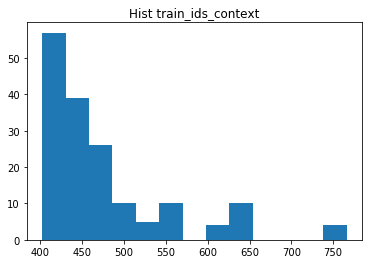

In [17]:
plt.hist(len_train_ids_context, bins='auto')
plt.title("Hist train_ids_context")
plt.show()

In [18]:
np.max(len_train_ids_context)

766

In [19]:
train_ids_question = read_ids_data(train_ids_question_path)

In [20]:
len_train_ids_question = [len(l) for l in train_ids_question if len(l) > FLAGS.question_max_length]

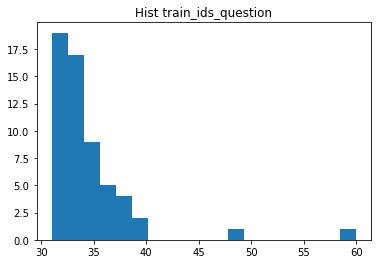

In [21]:
plt.hist(len_train_ids_question, bins='auto')
plt.title("Hist train_ids_question")
plt.show()

In [22]:
len(train_ids_question)

81403

In [23]:
len(train_ids_context)

81403

In [24]:
def pad_sequences(data, max_length):
    """Ensures each input-output seqeunce pair in @data is of length
    @max_length by padding it with zeros and truncating the rest of the
    sequence.
    check Assignment3 for more detail.
    """
    zero = '0'
    ret = []
    for sentence in data:
        len_sentence = len(sentence)
        mask = []
        for i in range(len_sentence):
          mask.append(True)
        for i in range(len_sentence,max_length):
          sentence.append(zero)
          mask.append(False)
        #ret.append((sentence[:max_length], mask[:max_length]))
        ret.append(mask)
    return ret    

In [25]:
len(train_ids_question[0])

17

In [26]:
train_ids_question[0][0:len(train_ids_question[0])]

['311',
 '9',
 '1334',
 '635',
 '6192',
 '56',
 '639',
 '452',
 '1086',
 '34',
 '8',
 '300',
 '9',
 '34',
 '10',
 '12330',
 '18']

In [27]:
train_mask_question = pad_sequences(train_ids_question, FLAGS.question_max_length)

In [28]:
train_ids_question[0][0:20]

['311',
 '9',
 '1334',
 '635',
 '6192',
 '56',
 '639',
 '452',
 '1086',
 '34',
 '8',
 '300',
 '9',
 '34',
 '10',
 '12330',
 '18',
 '0',
 '0',
 '0']

In [29]:
train_mask_question[0][0:20]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False]

In [30]:
len(train_ids_context[0])

86

In [31]:
train_ids_context[0][80:90]

['150', '364', '8', '87190', '184', '4']

In [32]:
train_mask_context = pad_sequences(train_ids_context, FLAGS.context_max_length)

In [33]:
len(train_ids_context[0])

400

In [34]:
train_ids_context[0][80:90]

['150', '364', '8', '87190', '184', '4', '0', '0', '0', '0']

In [35]:
train_mask_context[0][80:90]

[True, True, True, True, True, True, False, False, False, False]